# **Arboles de decisión con Python**

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn import datasets, manifold
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import seaborn as sns
from collections import defaultdict
from palmerpenguins import load_penguins

Trabajamos con un conjunto de caracteristicas de correos electrónicos. La finalidad es construir un clasificador en spam-nospam.

Cargar datos y ver primeras lineas
Leer descripción
http://search.r-project.org/library/kernlab/html/spam.html
En general funciona también help(spam) pero da problema en colab

In [2]:
penguins = load_penguins()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [3]:
penguins = penguins.dropna(axis=0, how="any")

# Create a new dataframe from 'penguins' without 'species' and 'island' columns.
data = penguins.drop(columns=['species', 'island','sex'])

data['female'] = penguins['sex'].map({'male': 0, 'female': 1})

target = penguins['species']

classes = ['Adelie', 'Chinstrap', 'Gentoo']

Separar conjunto de datos en train y test

In [4]:

# Splitting the dataset
train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=1601/4601, random_state=42
)

**Ajustar un arbol.**

La función base es rpart (recursive partitioning).

Con los valores en rpart.control se controla el arbol resultando
Ver: https://www.rdocumentation.org/packages/rpart/versions/4.1-15/topics/rpart.control

In [5]:

# Train decision tree with max depth 4
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(train_data, train_target)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [6]:

# Summary (Feature Importance)
print("Feature importances:")
print(pd.Series(clf.feature_importances_, index=data.columns))


Feature importances:
bill_length_mm       0.355659
bill_depth_mm        0.063800
flipper_length_mm    0.534457
body_mass_g          0.046084
year                 0.000000
female               0.000000
dtype: float64


**Visualizar arbol estimado.**



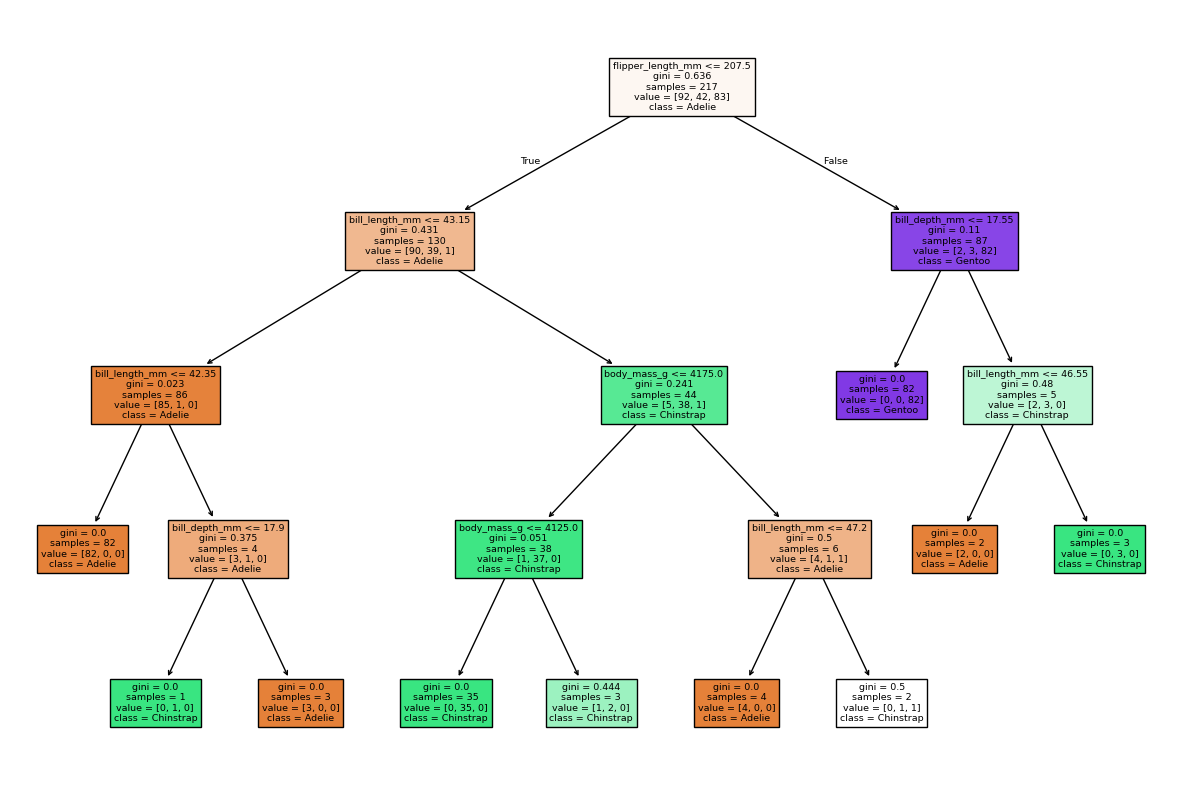

In [7]:

# Plot tree
plt.figure(figsize=(15, 10))
plot_tree(clf, feature_names=data.columns, class_names=classes, filled=True)
plt.show()

**Calcular errores sobre conjunto de prueba:**

Con la función predict se obtiene predicciones para datos nuevos.
       predict(arbol,newdata= ... ,type= ...)

Hay dos posibles salidas:

poniendo type="class" se regresa la predicci'on $\hat{y}(x)$

poniendo type="prob", se regresa la probabilidad  estimada que Y=1.
Las probabilidades corresponden más bien a las frecuencias relativas de cada clase en el elemento de la partición correspondiente.



In [8]:

# Predictions
class_predictions = clf.predict(test_data)


In [9]:
prob_predictions = clf.predict_proba(test_data)


**Hacer tabla de confusión:**

In [10]:

# Confusion Matrix
conf_matrix = confusion_matrix(test_target, class_predictions)


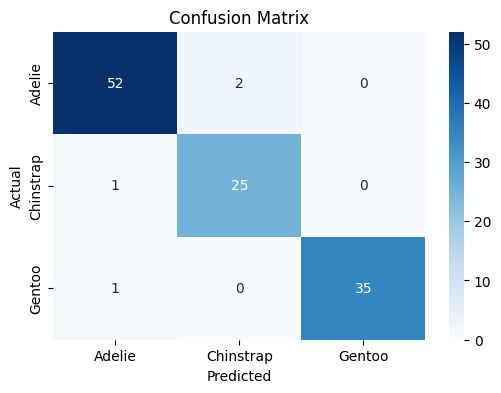

In [11]:

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [12]:

# Classification Report
print("Classification Report:")
print(classification_report(test_target, class_predictions))


Classification Report:
              precision    recall  f1-score   support

      Adelie       0.96      0.96      0.96        54
   Chinstrap       0.93      0.96      0.94        26
      Gentoo       1.00      0.97      0.99        36

    accuracy                           0.97       116
   macro avg       0.96      0.97      0.96       116
weighted avg       0.97      0.97      0.97       116



In [13]:

# Model Accuracy
accuracy = balanced_accuracy_score(test_target, class_predictions)
print(f"Model Accuracy: {accuracy:.4f}")


Model Accuracy: 0.9656


**Estimación usando la función de costo aumentada con el término $+\alpha size(T)$. En R se refiere con el parámetro cp a $\alpha$**

In [14]:

# Find optimal ccp_alpha for pruning
path = clf.cost_complexity_pruning_path(train_data, train_target)
ccp_alphas = path.ccp_alphas[:-1]  # Exclude max alpha which prunes everything

# Train trees with different alphas
clfs = [DecisionTreeClassifier(ccp_alpha=alpha, random_state=42).fit(train_data, train_target) for alpha in ccp_alphas]

# Compute accuracies
train_scores = [balanced_accuracy_score(train_target, clf.predict(train_data)) for clf in clfs]
test_scores = [balanced_accuracy_score(test_target, clf.predict(test_data)) for clf in clfs]


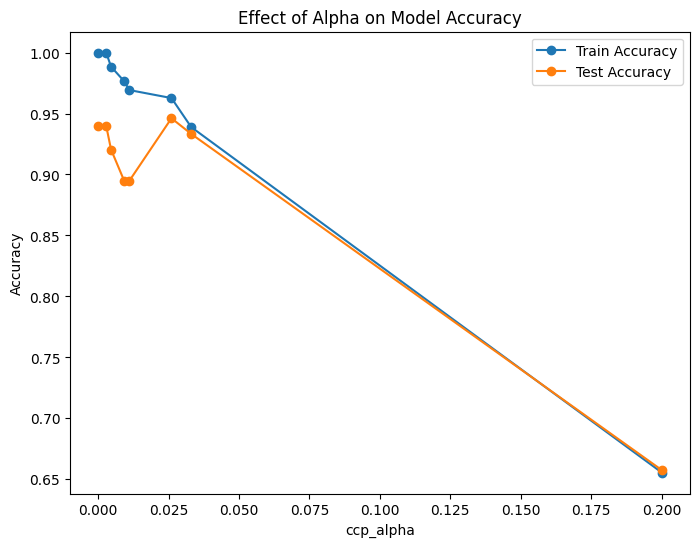

In [15]:

# Plot alpha vs accuracy
plt.figure(figsize=(8, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label='Train Accuracy')
plt.plot(ccp_alphas, test_scores, marker='o', label='Test Accuracy')
plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Effect of Alpha on Model Accuracy")
plt.show()


In [16]:

# Select best alpha (where test accuracy is maximized)
best_alpha = ccp_alphas[np.argmax(test_scores)]
print(f"Optimal ccp_alpha: {best_alpha:.6f}")


Optimal ccp_alpha: 0.026007


**Podar árboles**

In [17]:

# Train pruned decision tree
clf_pruned = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=42)
clf_pruned.fit(train_data, train_target)


DecisionTreeClassifier(ccp_alpha=np.float64(0.026007099861089667),
                       random_state=42)

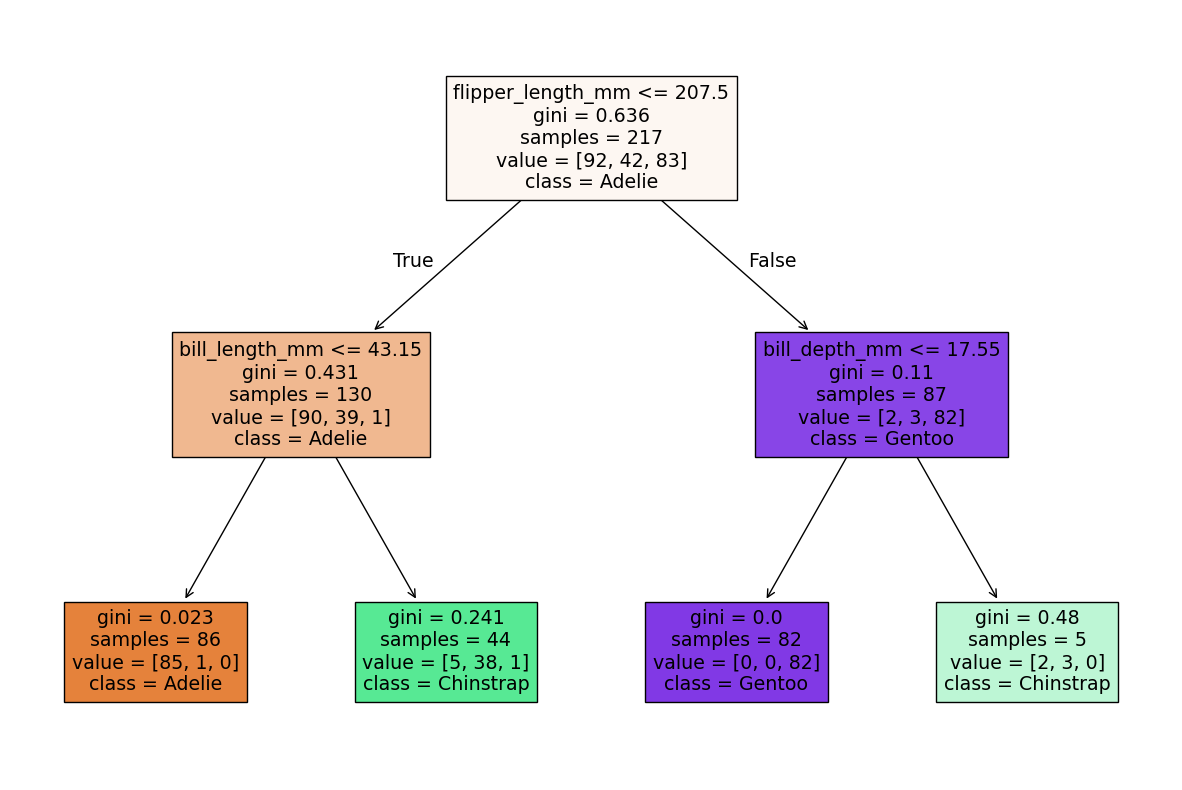

In [18]:

# Plot pruned tree
plt.figure(figsize=(15, 10))
plot_tree(clf_pruned, feature_names=data.columns, class_names=classes, filled=True)
plt.show()


In [19]:

# Predictions for pruned tree
class_predictions_pruned = clf_pruned.predict(test_data)


In [20]:

# Confusion Matrix for pruned tree
conf_matrix_pruned = confusion_matrix(test_target, class_predictions_pruned)


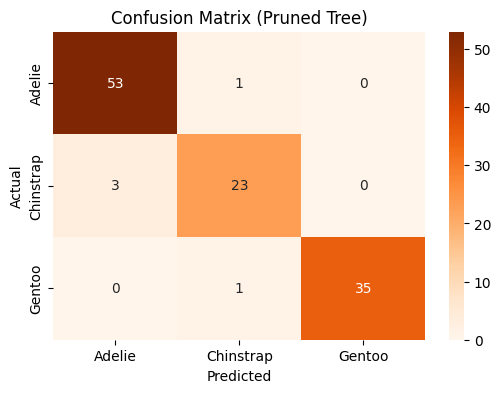

In [21]:

# Plot Confusion Matrix for pruned tree
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_pruned, annot=True, fmt="d", cmap="Oranges", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Pruned Tree)")
plt.show()


In [22]:

# Classification Report for pruned tree
print("Classification Report (Pruned Tree):")
print(classification_report(test_target, class_predictions_pruned))


Classification Report (Pruned Tree):
              precision    recall  f1-score   support

      Adelie       0.95      0.98      0.96        54
   Chinstrap       0.92      0.88      0.90        26
      Gentoo       1.00      0.97      0.99        36

    accuracy                           0.96       116
   macro avg       0.96      0.95      0.95       116
weighted avg       0.96      0.96      0.96       116



In [23]:

# Model Accuracy for pruned tree
accuracy_pruned = balanced_accuracy_score(test_target, class_predictions_pruned)
print(f"Model Accuracy (Pruned Tree): {accuracy_pruned:.4f}")


Model Accuracy (Pruned Tree): 0.9461


**K-NN**

In [24]:
max_k = 20
k_range = range(1, max_k + 1)
scores = []

In [25]:
for k in k_range:
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(train_data, train_target)  # Fit the model on training data
    predictions = knn_clf.predict(test_data)  # Predict on test data
    
    # Calculate performance metric (e.g., accuracy)
    score = balanced_accuracy_score(test_target, predictions)
    scores.append(score)

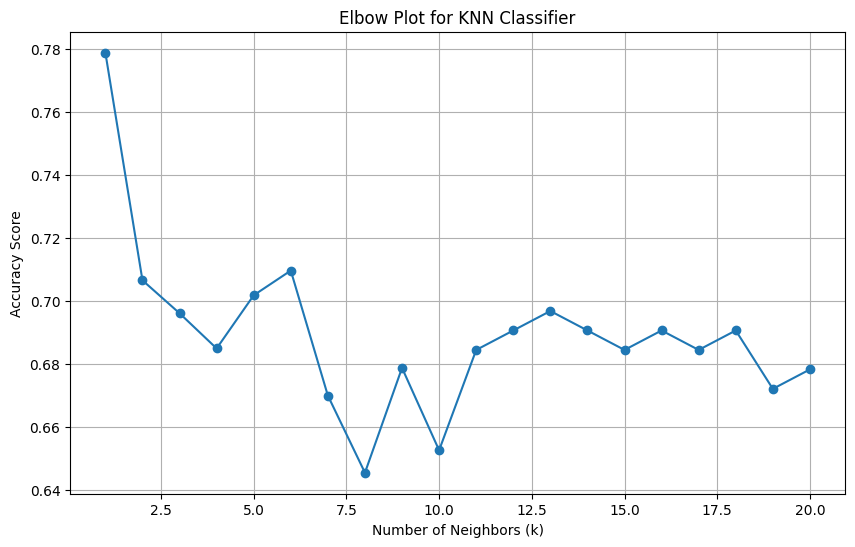

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o')
plt.title('Elbow Plot for KNN Classifier')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.show()

In [27]:
neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(train_data, train_target)
class_predictions_neigh = neigh.predict(test_data)

In [28]:

# Confusion Matrix for pruned tree
conf_matrix_neigh = confusion_matrix(test_target, class_predictions_neigh)


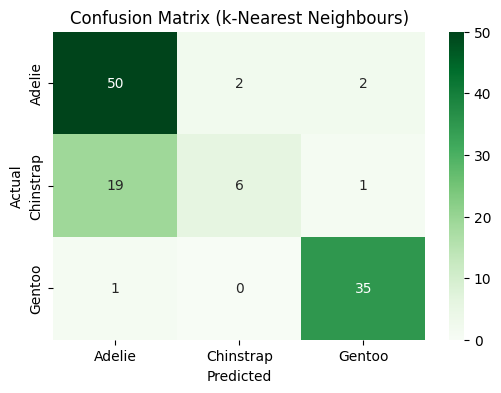

In [29]:

# Plot Confusion Matrix for pruned tree
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_neigh, annot=True, fmt="d", cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (k-Nearest Neighbours)")
plt.show()


In [30]:

# Classification Report for pruned tree
print("Classification Report (k-Nearest Neighbours):")
print(classification_report(test_target, class_predictions_neigh))


Classification Report (k-Nearest Neighbours):
              precision    recall  f1-score   support

      Adelie       0.71      0.93      0.81        54
   Chinstrap       0.75      0.23      0.35        26
      Gentoo       0.92      0.97      0.95        36

    accuracy                           0.78       116
   macro avg       0.80      0.71      0.70       116
weighted avg       0.79      0.78      0.75       116



In [31]:

# Model Accuracy for pruned tree
accuracy_neigh = balanced_accuracy_score(test_target, class_predictions_neigh)
print(f"Model Accuracy (k-Nearest Neighbours): {accuracy_neigh:.4f}")


Model Accuracy (k-Nearest Neighbours): 0.7096


In [32]:
X_train = train_data.values
X_test = test_data.values

In [33]:
import numpy as np
from scipy.stats import norm

class NaiveBayesGaussian:
    def __init__(self):
        self.classes = None
        self.class_map = {}
        self.priors = {}
        self.means = {}
        self.variances = {}
        self.alpha = 1.0  # Laplace smoothing parameter
        
    def fit(self, X_train, y_train):
        """Fit the Naïve Bayes classifier assuming Gaussian distributions with Laplace smoothing."""
        # Map non-numeric class labels to integers
        self.classes = np.unique(y_train)
        self.class_map = {label: idx for idx, label in enumerate(self.classes)}
        y_train_encoded = np.array([self.class_map[label] for label in y_train])

        n_samples, n_features = X_train.shape
        for c in self.classes:
            X_c = X_train[y_train_encoded == self.class_map[c]]
            
            # Add Laplace smoothing to prior probabilities
            count = len(X_c)
            self.priors[c] = (count + self.alpha) / (n_samples + self.alpha * len(self.classes))
            
            if n_features > 0:
                # Calculate the mean for each feature per class
                self.means[c] = np.mean(X_c, axis=0)
                # Calculate the variance for each feature per class
                self.variances[c] = np.var(X_c, axis=0, ddof=1) + 1e-8
            else:
                self.means[c] = 0.0
                self.variances[c] = 1e-8
                
    def _classify(self, x):
        """Classify a single sample using the Naive Bayes classifier with Laplace smoothing."""
        posteriors = {}
        for c in self.classes:
            prior = np.log(self.priors[c])
            likelihood = np.sum(norm.logpdf(x.astype(np.float64), self.means[c].astype(np.float64), np.sqrt(self.variances[c]).astype(np.float64)))
            posteriors[c] = prior + likelihood
        # Return class with highest posterior probability
        return max(posteriors, key=posteriors.get)

    def predict(self, X_test):
        """Predict the class labels for input samples."""
        X_test = X_test.astype(np.float64)  # Ensure correct data type for testing
        predictions = [self._classify(x) for x in X_test]
        # Map the numeric class predictions back to original class labels
        return np.array([self.classes[self.class_map[class_pred]] for class_pred in predictions])


In [34]:
nb = NaiveBayesGaussian()
nb.fit(X_train, train_target)

class_predictions_nb = nb.predict(X_test)

In [35]:

# Confusion Matrix for pruned tree
conf_matrix_nb = confusion_matrix(test_target, class_predictions_nb)


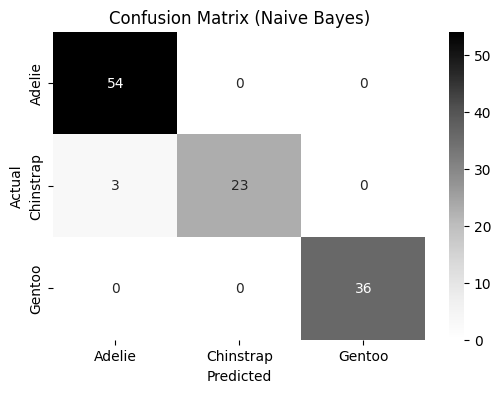

In [36]:

# Plot Confusion Matrix for pruned tree
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Greys", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Naive Bayes)")
plt.show()


In [37]:

# Classification Report for pruned tree
print("Classification Report (Naive Bayes):")
print(classification_report(test_target, class_predictions_nb))


Classification Report (Naive Bayes):
              precision    recall  f1-score   support

      Adelie       0.95      1.00      0.97        54
   Chinstrap       1.00      0.88      0.94        26
      Gentoo       1.00      1.00      1.00        36

    accuracy                           0.97       116
   macro avg       0.98      0.96      0.97       116
weighted avg       0.98      0.97      0.97       116



In [38]:

# Model Accuracy for pruned tree
accuracy_nb = balanced_accuracy_score(test_target, class_predictions_nb)
print(f"Model Accuracy (Naive Bayes): {accuracy_nb:.4f}")


Model Accuracy (Naive Bayes): 0.9615
